In [108]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from mygrad import sliding_window_view

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv1D
import tensorflow as tf

%matplotlib notebook

Functions from POMS_sentiment used to load existing dictionary

In [3]:
def load_sent_dict(path="sent_dict.txt"):
    with open(path, "rb") as f:
        return pickle.load(f)

def save_sent_dict(sent_dict, path="sent_dict.txt"):
    with open(path, "wb") as f:
        pickle.dump(sent_dict, f, pickle.HIGHEST_PROTOCOL)

def sentiment_time_series(sent_dict, key):
    N = max(sent_dict.keys())
    
    T = np.ndarray((N,))
    for i in range(N):
        T[i] = sent_dict[i][key]
        
    #convert to z-scores
    mean = np.mean(T)
    std  = np.std(T)
    T = (T - mean) / std
        
    return T

In [4]:
sent_dict = load_sent_dict()

Functions from DJIA_preprocess used to load DJIA data

In [5]:
def load_djia(path="djia_ts.txt"):
    with open(path, "rb") as f:
        return pickle.load(f)

def save_djia(ts, path="djia_ts.txt"):
    with open(path, "wb") as f:
        pickle.dump(ts, f, pickle.HIGHEST_PROTOCOL)

In [6]:
djia = load_djia()

Load in relevant part of the DJIA data for training, zscore it, and create time series for Calm and Happy

In [7]:
train_djia = djia[130:130+98]
train_djia = (train_djia - np.mean(train_djia)) / np.std(train_djia)

In [8]:
calm = -sentiment_time_series(sent_dict, "tension") - sentiment_time_series(sent_dict, "anger")
happy = sentiment_time_series(sent_dict, "vigour") - sentiment_time_series(sent_dict, "depression")
alert = -sentiment_time_series(sent_dict, "fatigue") - sentiment_time_series(sent_dict, "confusion")

This function creates a dataset by looking at "windows" of previous time series values. In other words, we're trying to predict a stock value on each day by looking at sentiment data in the past $N$ days. Obviously this means we can't do predictions for the first $N$ days which makes sense.

Experiment: to augment time series data with previous returns, you could attempt to pass DJIA data to this function as well as other time series.

We can then easily generate our training data using a call of this function.

In [9]:
def windowed_data(window_size, *ts_data):
    dataset = np.ndarray((len(ts_data[0]) - window_size + 1, window_size * len(ts_data)))
    
    for i, ts in enumerate(ts_data):
        dataset[:,window_size*i:window_size*(i+1)] = sliding_window_view(ts, (window_size,), 1)
    
    return dataset[:-1]

In [10]:
N = 10
x_train = windowed_data(N, calm, happy, alert)
y_train = train_djia[N:]

This function will test any of our prediction algorithms by a simple cross validation.

In [11]:
def cross_validate_model(k, x_data, y_data, model):
    size = int(len(x_data) / k)
    
    prediction = np.zeros(y_data.shape)
        
    for i in range(k):
        
        if i == k-1:
            x_train = x_data[:i*size]
            y_train = y_data[:i*size]

            x_test = x_data[i*size:]
            y_test = y_data[i*size:]
            
            prediction[i*size:] = model(x_test, x_train, y_train)
        else:
            x_train = np.concatenate((x_data[:i*size], x_data[(i+1)*size:]))
            y_train = np.concatenate((y_data[:i*size], y_data[(i+1)*size:]))

            x_test = x_data[i*size:(i+1)*size]
            y_test = y_data[i*size:(i+1)*size]
        
            prediction[i*size:(i+1)*size] = model(x_test, x_train, y_train)
        
    return prediction

def mape(truth, prediction):
    #return np.abs(truth - prediction)
    return np.mean(np.abs((truth - prediction) / truth))

def rmse(truth, prediction):
    return np.sqrt(np.mean((truth - prediction) ** 2))

def accuracy(truth, prediction, lag):
    length = len(truth)
    correct = 0.0
    for i in range(lag,length):
        lastTruth = np.mean(truth[i-lag:i])
        lastPred  = np.mean(prediction[i-lag:i])
        if (truth[i] >= lastTruth and prediction[i] >= lastPred):
            correct += 1
        elif (truth[i] <= lastTruth and prediction[i] <= lastPred):
            correct += 1
    
    return correct / (length - lag)

Our first (very simple) prediction algorithm: linear regression

In [12]:
def linreg_prediction(A, x_train, y_train):
    factor = np.linalg.lstsq(x_train, y_train, rcond=None)[0]
    return np.matmul(A, factor)

<IPython.core.display.Javascript object>


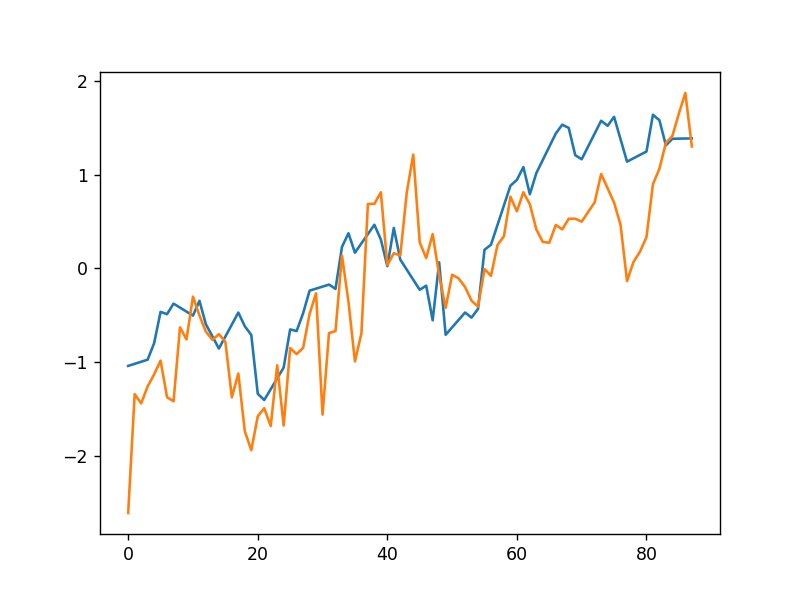

In [13]:
fig, ax = plt.subplots()
ax.plot(y_train)
ax.plot(cross_validate_model(5, x_train, y_train, linreg_prediction))

In [154]:
rmse(y_train, cross_validate_model(5, x_train, y_train, linreg_prediction))

0.6413801263895541

In [137]:
model = Sequential()
model.add(Dense(128, input_shape=(30,), activation="sigmoid"))
model.add(Dense(32, activation="sigmoid"))
model.add(Dense(16, activation="sigmoid"))
model.add(Dense(1, activation="linear"))

model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

In [138]:
history = model.fit(x_train, y_train, epochs=150, batch_size=20, verbose=1)

Train on 44 samples, validate on 44 samples
Epoch 1/150
44/44 [==============================] - 1s 19ms/step - loss: 0.3283 - mean_squared_error: 0.3283 - mean_absolute_error: 0.4605 - val_loss: 2.5562 - val_mean_squared_error: 2.5562 - val_mean_absolute_error: 1.4102
Epoch 2/150
44/44 [==============================] - 0s 567us/step - loss: 0.2713 - mean_squared_error: 0.2713 - mean_absolute_error: 0.4200 - val_loss: 2.2600 - val_mean_squared_error: 2.2600 - val_mean_absolute_error: 1.3154
Epoch 3/150
44/44 [==============================] - 0s 612us/step - loss: 0.2425 - mean_squared_error: 0.2425 - mean_absolute_error: 0.3931 - val_loss: 2.0944 - val_mean_squared_error: 2.0944 - val_mean_absolute_error: 1.2663
Epoch 4/150
44/44 [==============================] - 0s 748us/step - loss: 0.2279 - mean_squared_error: 0.2279 - mean_absolute_error: 0.3827 - val_loss: 1.9510 - val_mean_squared_error: 1.9510 - val_mean_absolute_error: 1.2242
Epoch 5/150
44/44 [==============================

Epoch 37/150
44/44 [==============================] - 0s 544us/step - loss: 0.0540 - mean_squared_error: 0.0540 - mean_absolute_error: 0.1936 - val_loss: 1.1578 - val_mean_squared_error: 1.1578 - val_mean_absolute_error: 0.9223
Epoch 38/150
44/44 [==============================] - 0s 431us/step - loss: 0.0511 - mean_squared_error: 0.0511 - mean_absolute_error: 0.1904 - val_loss: 1.1672 - val_mean_squared_error: 1.1672 - val_mean_absolute_error: 0.9239
Epoch 39/150
44/44 [==============================] - 0s 589us/step - loss: 0.0492 - mean_squared_error: 0.0492 - mean_absolute_error: 0.1895 - val_loss: 1.1742 - val_mean_squared_error: 1.1742 - val_mean_absolute_error: 0.9253
Epoch 40/150
44/44 [==============================] - 0s 589us/step - loss: 0.0474 - mean_squared_error: 0.0474 - mean_absolute_error: 0.1887 - val_loss: 1.1651 - val_mean_squared_error: 1.1651 - val_mean_absolute_error: 0.9217
Epoch 41/150
44/44 [==============================] - 0s 634us/step - loss: 0.0458 - mea

Epoch 73/150
44/44 [==============================] - 0s 544us/step - loss: 0.0144 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0969 - val_loss: 0.8484 - val_mean_squared_error: 0.8484 - val_mean_absolute_error: 0.8122
Epoch 74/150
44/44 [==============================] - 0s 453us/step - loss: 0.0144 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0979 - val_loss: 0.8410 - val_mean_squared_error: 0.8410 - val_mean_absolute_error: 0.8098
Epoch 75/150
44/44 [==============================] - 0s 544us/step - loss: 0.0140 - mean_squared_error: 0.0140 - mean_absolute_error: 0.0968 - val_loss: 0.8404 - val_mean_squared_error: 0.8404 - val_mean_absolute_error: 0.8099
Epoch 76/150
44/44 [==============================] - 0s 499us/step - loss: 0.0134 - mean_squared_error: 0.0134 - mean_absolute_error: 0.0939 - val_loss: 0.8418 - val_mean_squared_error: 0.8418 - val_mean_absolute_error: 0.8107
Epoch 77/150
44/44 [==============================] - 0s 544us/step - loss: 0.0136 - mea

Epoch 109/150
44/44 [==============================] - 0s 544us/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0710 - val_loss: 0.8179 - val_mean_squared_error: 0.8179 - val_mean_absolute_error: 0.8020
Epoch 110/150
44/44 [==============================] - 0s 499us/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0710 - val_loss: 0.8085 - val_mean_squared_error: 0.8085 - val_mean_absolute_error: 0.7981
Epoch 111/150
44/44 [==============================] - 0s 589us/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0713 - val_loss: 0.8083 - val_mean_squared_error: 0.8083 - val_mean_absolute_error: 0.7979
Epoch 112/150
44/44 [==============================] - 0s 544us/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0700 - val_loss: 0.8145 - val_mean_squared_error: 0.8145 - val_mean_absolute_error: 0.8002
Epoch 113/150
44/44 [==============================] - 0s 544us/step - loss: 0.0080 

Epoch 145/150
44/44 [==============================] - 0s 544us/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0563 - val_loss: 0.8022 - val_mean_squared_error: 0.8022 - val_mean_absolute_error: 0.7960
Epoch 146/150
44/44 [==============================] - 0s 499us/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0557 - val_loss: 0.8127 - val_mean_squared_error: 0.8127 - val_mean_absolute_error: 0.7998
Epoch 147/150
44/44 [==============================] - 0s 521us/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0550 - val_loss: 0.8135 - val_mean_squared_error: 0.8135 - val_mean_absolute_error: 0.8000
Epoch 148/150
44/44 [==============================] - 0s 612us/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0542 - val_loss: 0.8107 - val_mean_squared_error: 0.8107 - val_mean_absolute_error: 0.7991
Epoch 149/150
44/44 [==============================] - 0s 589us/step - loss: 0.0050 

<IPython.core.display.Javascript object>


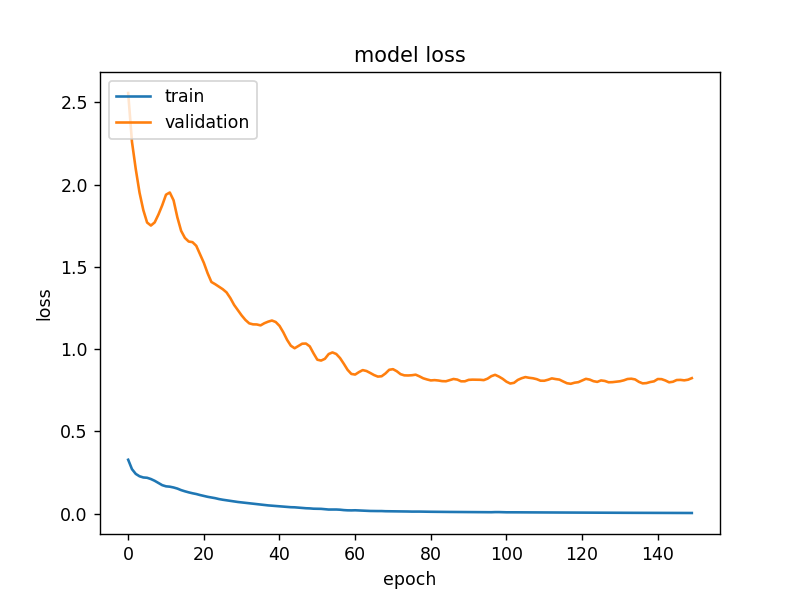

In [140]:
fig, ax = plt.subplots()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [147]:
def dense_prediction(A, x_train, y_train):
    model = Sequential()
    model.add(Dense(128, input_shape=(30,), activation="sigmoid"))
    model.add(Dense(32, activation="sigmoid"))
    model.add(Dense(16, activation="sigmoid"))
    model.add(Dense(1, activation="linear"))

    model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])
    model.fit(x_train, y_train, epochs=150, batch_size=20, verbose=0)
    
    return model.predict(A).flatten()

In [148]:
dense_output = cross_validate_model(5, x_train, y_train, dense_prediction)

array([-1.05798471, -1.01234293, -1.00435042, -1.0048759 , -1.011711  ,
       -1.00050497, -1.01949179, -1.02985382, -0.99690676, -0.97781384,
       -0.91589248, -0.94019306, -0.92579371, -0.96436602, -0.96224916,
       -0.97271919, -0.97308457, -0.60601968, -0.6940527 , -0.73597747,
       -0.78867704, -0.79543889, -0.83503729, -0.79980105, -0.80672431,
       -0.79310316, -0.78169584, -0.72376233, -0.60065401, -0.66185677,
       -0.65823925, -0.61229199, -0.59034288, -0.26358736,  0.44247732,
        0.19106521,  0.35720235,  0.72756517,  0.72292519,  1.09337366,
        0.76550829,  0.58891177,  0.41845885,  0.83194935,  1.1743542 ,
        1.22817767,  1.22384334,  1.06810009,  0.53122914,  0.18758978,
        0.49836782, -0.37312075, -0.18636854, -0.40883389, -0.66982698,
        0.02013942, -0.17270467,  0.44689694,  0.40749767,  1.09018123,
        0.9522413 ,  1.28572309,  1.10388422,  0.54216057,  0.4935886 ,
        0.02889675,  0.66959804,  0.40304446,  0.61535913,  0.70

<IPython.core.display.Javascript object>


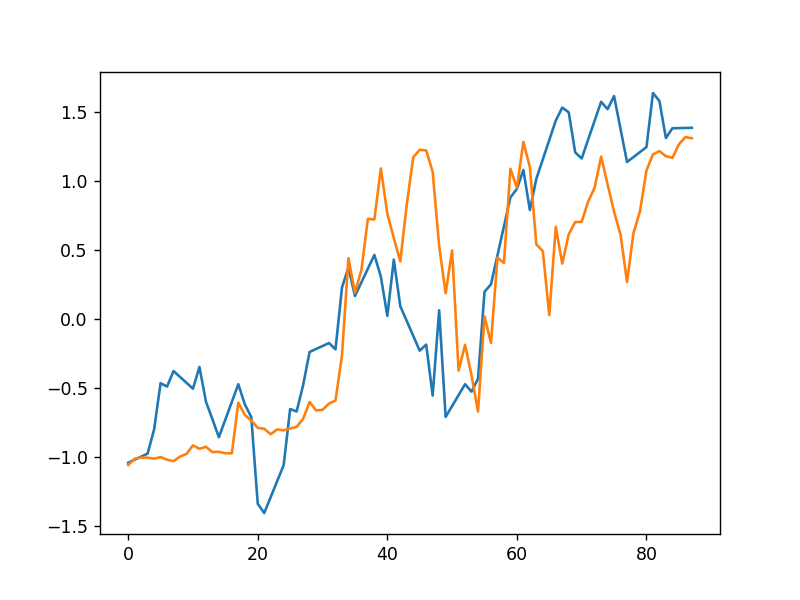

In [152]:
fig, ax = plt.subplots()
ax.plot(y_train)
ax.plot(pred)

In [162]:
accuracy(y_train, dense_output, 1)

0.5402298850574713